In [62]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import seaborn as sns
import xlsxwriter
import scipy.stats as stats
import os,sys
import pickle
import random
import math
import time
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from collections import OrderedDict
import pandas as pd
import shapefile as shp
import geopandas as gpd
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from get_population_by_state import GetAgeSex
import seaborn as sns
import matplotlib.gridspec as gridspec


In [85]:
county_shape_file = "data/basemap/cb_2018_us_county_5m"
state_shape_file = "data/basemap/cb_2018_us_state_5m"
data_no2 = "data/lur_no2/lur_no2_merged_with_pop_v10.csv"
data_pm25 = "data/lur_no2/lur_pm2.5_merged_with_pop_v10.csv"
data_pm10 = "data/lur_no2/lur_pm10_merged_with_pop_v10.csv"

In [86]:
df_no2 = pd.read_csv(data_no2)
df_pm25 = pd.read_csv(data_pm25)
df_pm10 = pd.read_csv(data_pm10)


In [87]:
def process(df):
    mdf = df.groupby(['year']).agg({"pred_wght": list}).reset_index()
    mdf['conc'] = mdf['pred_wght'].apply(lambda x: [i for i in x if not pd.isna(i)])
    mdf['max'] = mdf['conc'].apply(lambda x: max(x) if len(x)>0 else np.nan)
    return mdf

def process_state(df):
    mdf = df.groupby(['state_code', 'year']).agg({"pred_wght": list}).reset_index()
    mdf['conc'] = mdf['pred_wght'].apply(lambda x: [i for i in x if not pd.isna(i)])
    mdf['max'] = mdf['conc'].apply(lambda x: max(x) if len(x)>0 else np.nan)
    return mdf

df_no2 = process(df_no2)
df_pm25 = process(df_pm25)
df_pm10 = process(df_pm10)

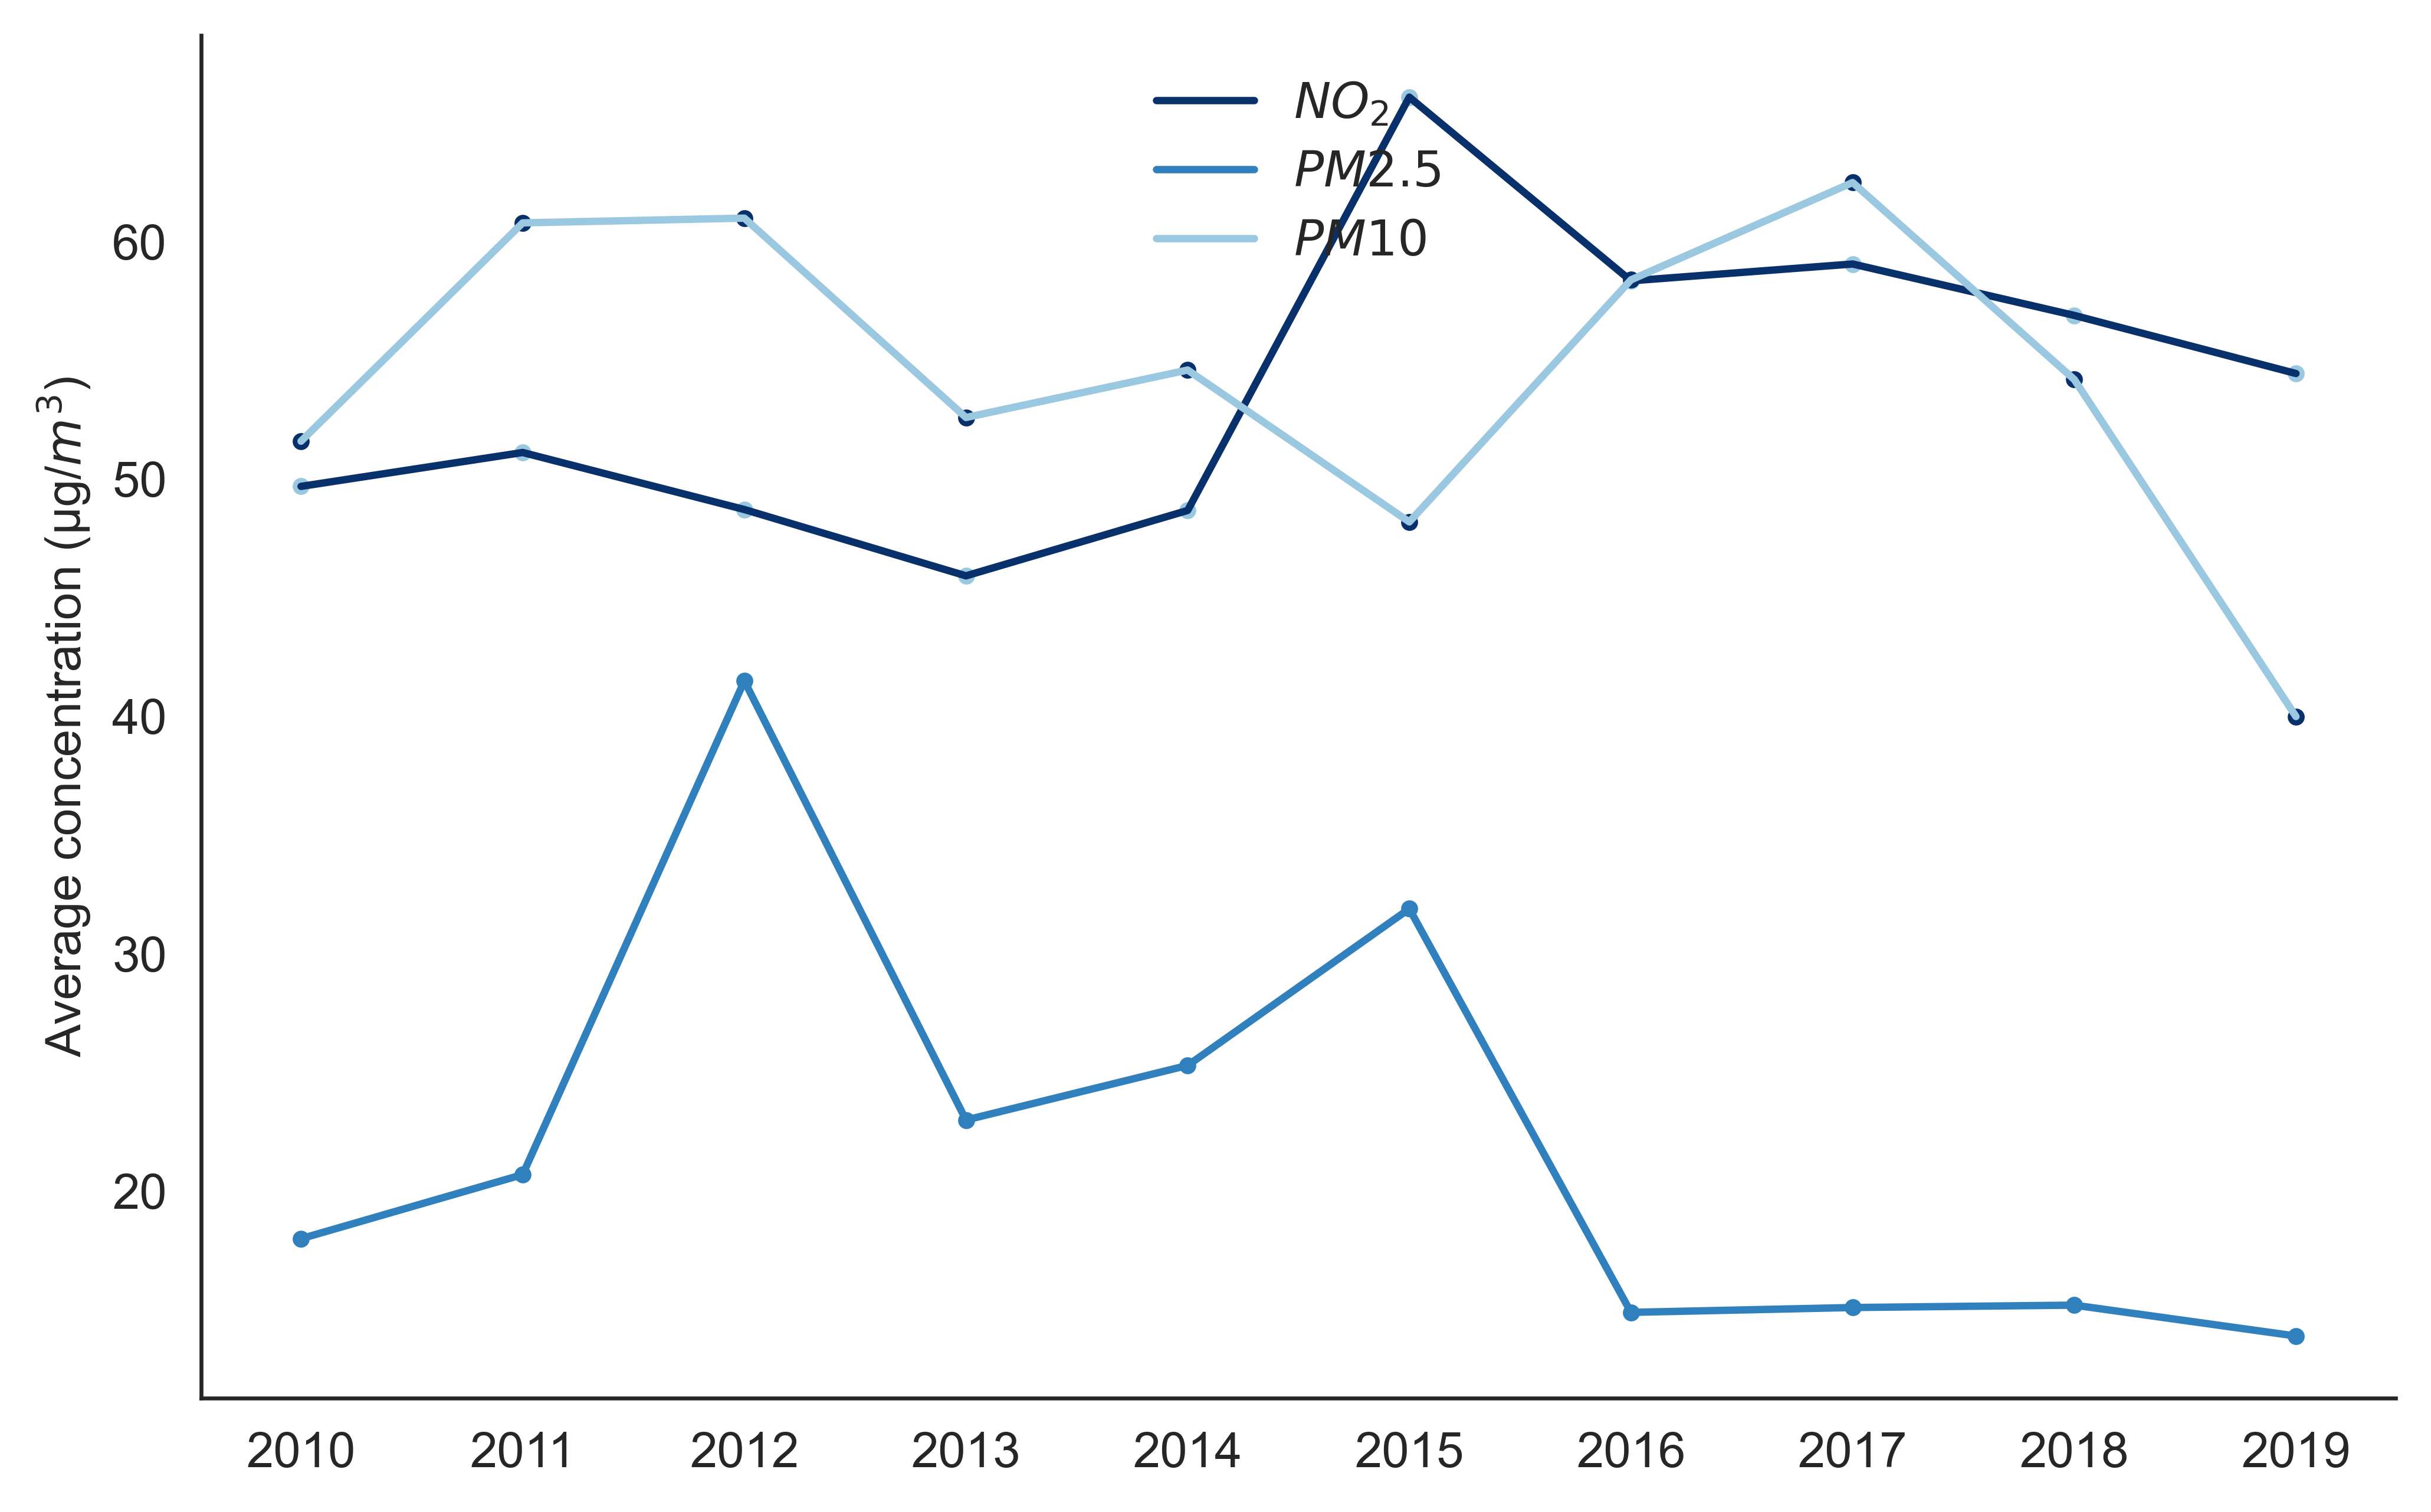

In [88]:
sns.set_style("white")
cmap = plt.get_cmap('Blues')
norm = Normalize(vmin=-1.5, vmax=5)
mapper = ScalarMappable(norm=norm, cmap=cmap)

plt.close()
plt.subplots(figsize=(8,5), dpi=600)
x, y = df_no2['year'].tolist(), df_no2['max']
plt.scatter(x,y, s=6, color=mapper.to_rgba(1))
plt.plot(x,y, label='$NO_2$', color=mapper.to_rgba(5))

x, y = df_pm25['year'].tolist(), df_pm25['max']
plt.plot(x,y, label='$PM 2.5$', color=mapper.to_rgba(3))
plt.scatter(x,y, s=6, color=mapper.to_rgba(3))

x, y = df_pm10['year'].tolist(), df_pm10['max']
plt.plot(x,y, label='$PM 10$', color=mapper.to_rgba(1))
plt.scatter(x,y, s=6, color=mapper.to_rgba(5))


plt.legend(loc='upper center', frameon=False)
plt.ylabel("Average concentration (μg/$m^3$)")
plt.xticks(x,x)
sns.despine()
plt.savefig("output_images/Figure_2.png", dpi=600, bbox_inches='tight')

In [89]:
epa_region = pd.read_csv("data/states_and_counties.csv")
epa_region = epa_region[['State Name', 'State Code', 'EPA Region']]
epa_region = epa_region[epa_region['State Code'] != 'CC']
epa_region['State Code'] = epa_region['State Code'].apply(int)
epa_region = epa_region.drop_duplicates(['State Code'], keep='first')

state_lookup = {row['State Code']:row['State Name'] for index, row in epa_region.iterrows()}

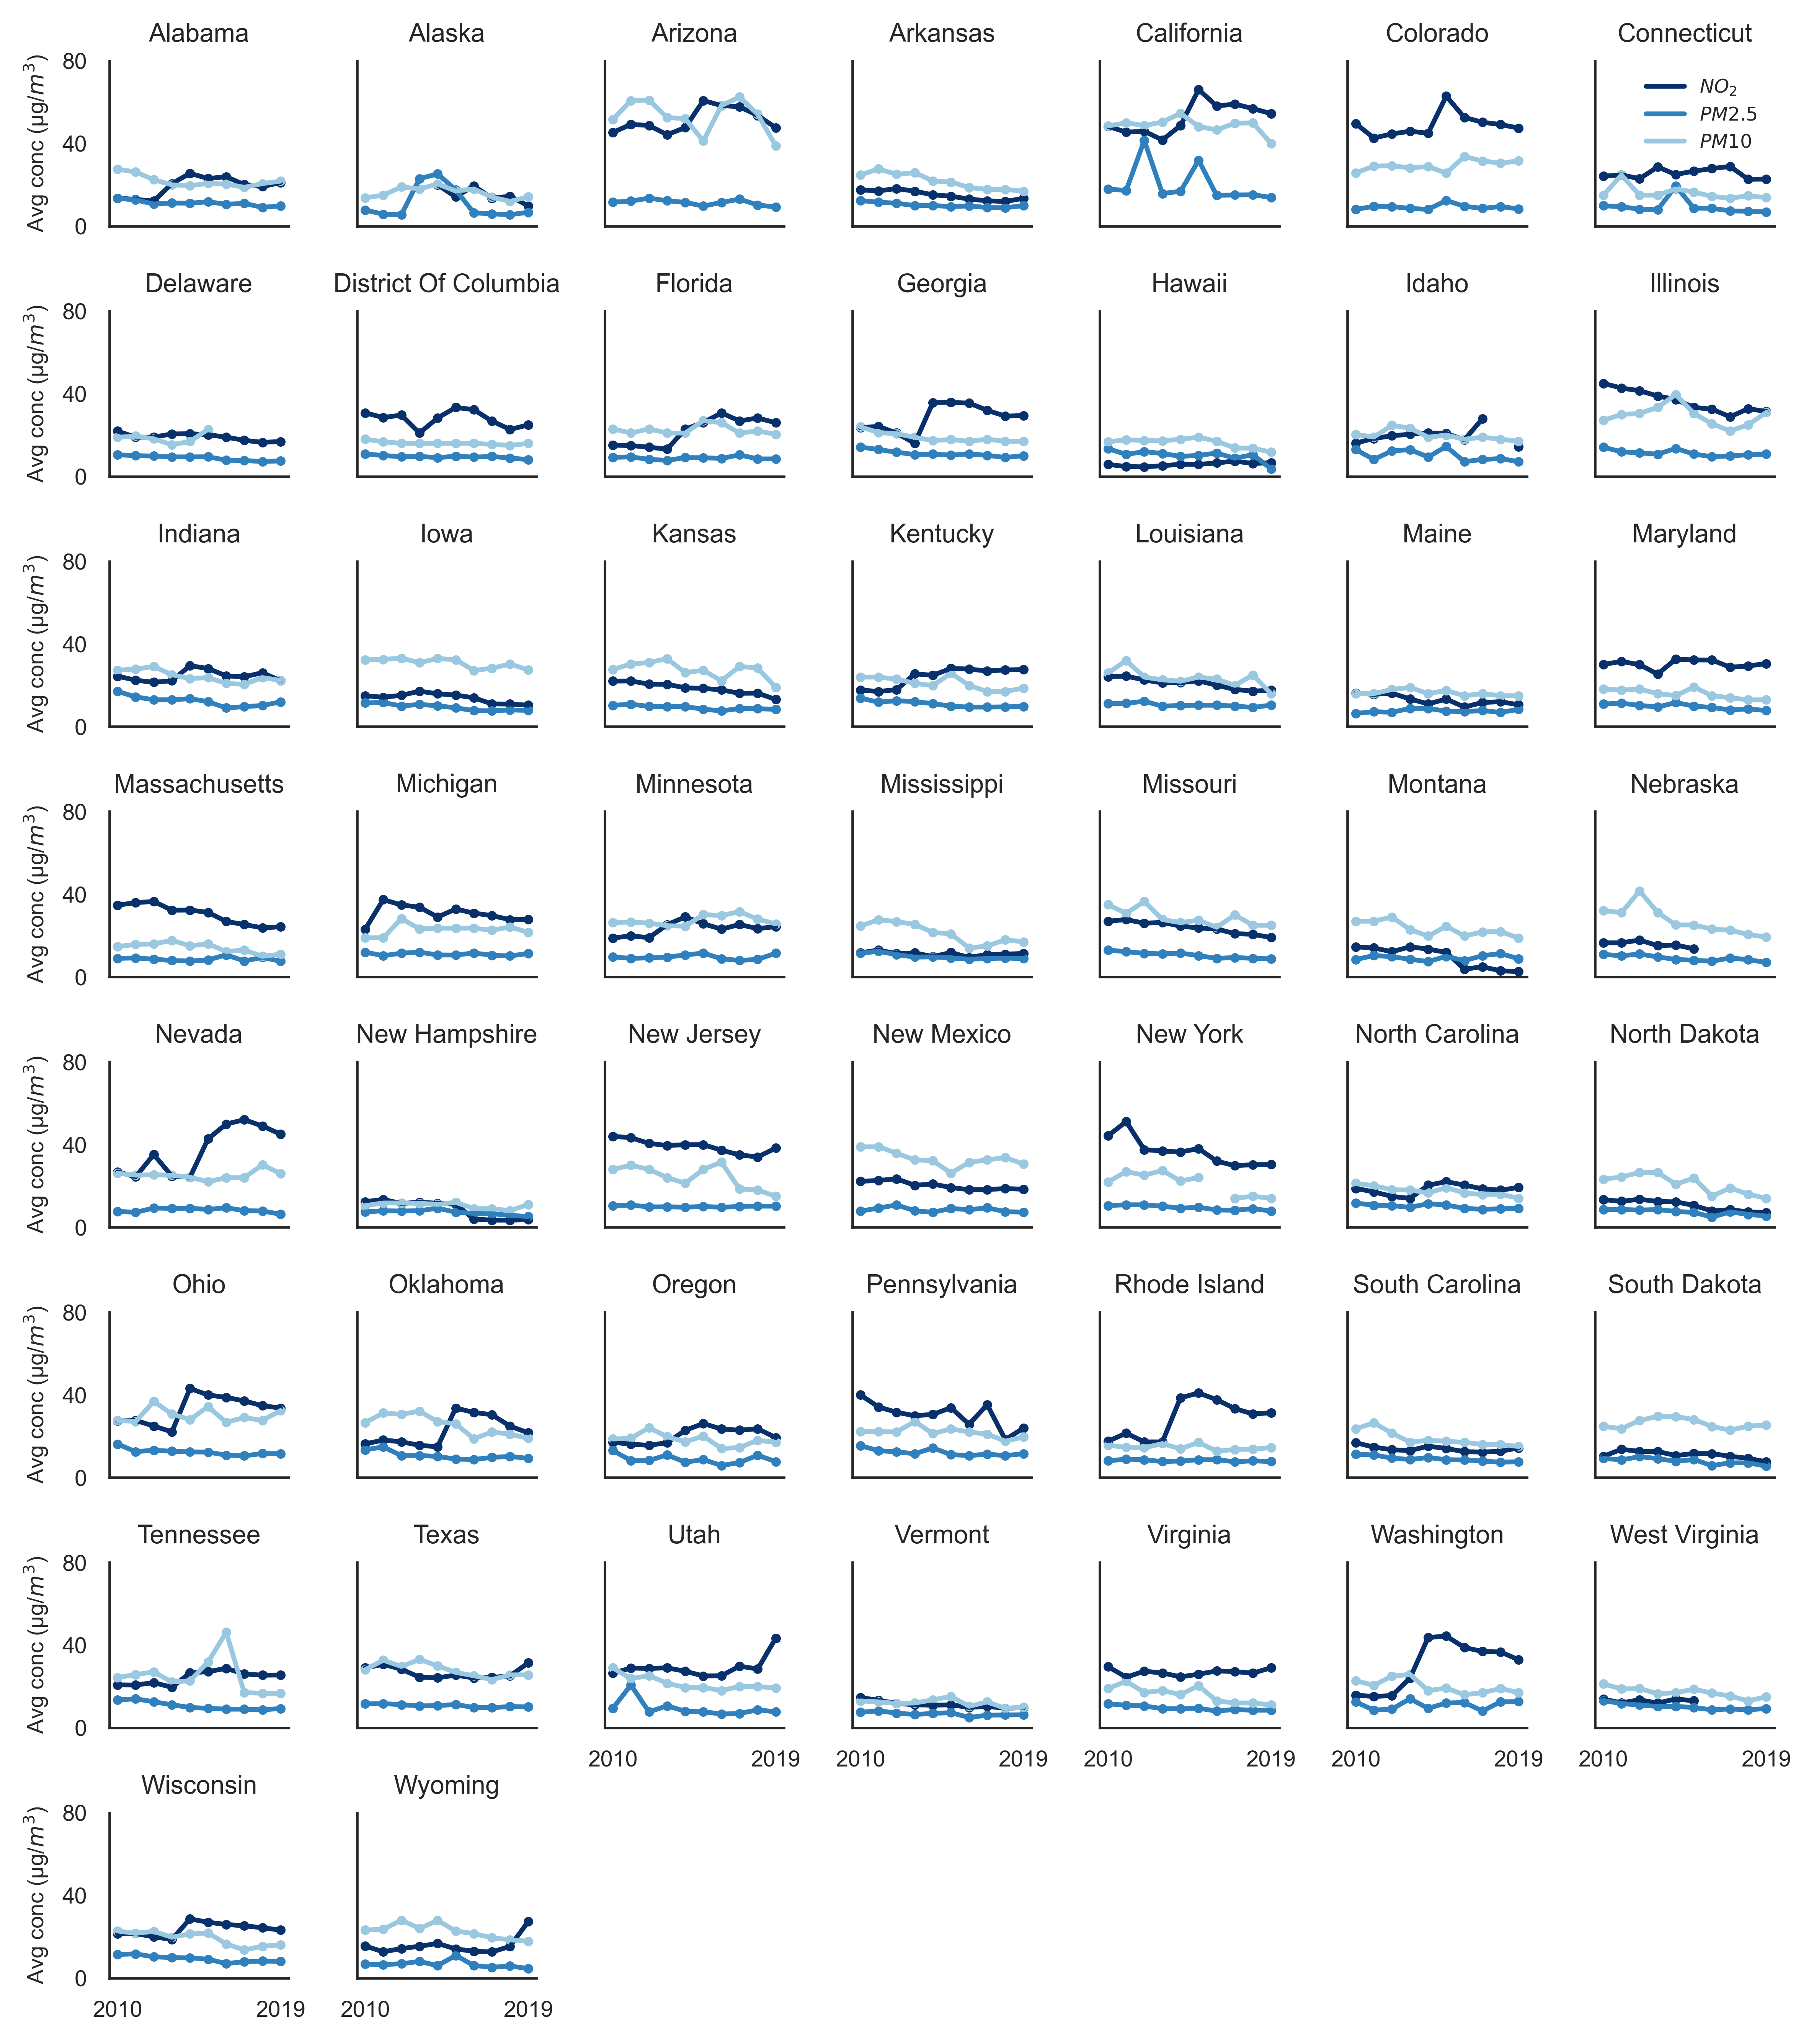

In [90]:
def pltplot(plt, df_no2, df_pm25, df_pm10):
    x, y = df_no2['year'].tolist(), df_no2['max']
    plt.scatter(x,y, s=4, color=mapper.to_rgba(5))
    plt.plot(x,y, label='$NO_2$', color=mapper.to_rgba(5))

    x, y = df_pm25['year'].tolist(), df_pm25['max']
    plt.plot(x,y, label='$PM 2.5$', color=mapper.to_rgba(3))
    plt.scatter(x,y, s=4, color=mapper.to_rgba(3))

    x, y = df_pm10['year'].tolist(), df_pm10['max']
    plt.plot(x,y, label='$PM 10$', color=mapper.to_rgba(1))
    plt.scatter(x,y, s=4, color=mapper.to_rgba(1))
    plt.ylim(0, 80)
    sns.despine()
    return plt



df_no2 = pd.read_csv(data_no2)
df_pm25 = pd.read_csv(data_pm25)
df_pm10 = pd.read_csv(data_pm10)

df_no2 = process_state(df_no2)
df_pm25 = process_state(df_pm25)
df_pm10 = process_state(df_pm10)
plt.close()
plt.figure(figsize=(8, 9), dpi=600)
row, col = 0, 0
maxrow, maxcol = 8, 7
gs = gridspec.GridSpec(maxrow, maxcol)
EXCLUDE = []
for index, state_code in enumerate(df_no2['state_code'].unique()):
    if state_code not in EXCLUDE:
        ax = plt.subplot(gs[row, col])
    #     ax.text(-0.1, 1, "{})".format(chr(97+index)), transform=ax.transAxes, size=16, color='black')
        tdf_no2 = df_no2[df_no2['state_code'] == state_code]
        tdf_pm25 = df_pm25[df_pm25['state_code'] == state_code]
        tdf_pm10 = df_pm10[df_pm10['state_code'] == state_code]

        plt = pltplot(plt, tdf_no2, tdf_pm25, tdf_pm10)
        plt.title(state_lookup.get(state_code), size=8)
        if row==0 and col==maxcol-1:
            plt.legend(loc='upper right', frameon=False, prop={'size': 6})
        if col == 0:
            plt.ylabel("Avg conc (μg/$m^3$)", size=7)
            plt.yticks([0, 40, 80], [0, 40, 80],size=7)
        else:
            plt.yticks([], [])

        if row == maxrow-1 or (row == maxrow-2 and col>=2):
            plt.xticks(x,['2010', '', '', '', '', '', '', '', '', '2019'], size = 7)
        else:
            plt.xticks([], [])

        if col == maxcol-1:
            col = 0
            row+=1
        else:
            col+=1
        
plt.tight_layout()
plt.savefig("output_images/statewise_pol_conc.png", dpi=600, bbox_inches='tight')
plt.show()

In [43]:
df = df_no2
epa_region = pd.read_csv("data/states_and_counties.csv")
epa_region = epa_region[['State Name', 'State Code', 'EPA Region']]
epa_region = epa_region[epa_region['State Code'] != 'CC']
epa_region['State Code'] = epa_region['State Code'].apply(int)
epa_region = epa_region.drop_duplicates(['State Code'], keep='first')

df = df.merge(epa_region, left_on='state_code', right_on='State Code', how='left')

mdf = df.groupby(['state_code', 'year']).agg({'pred_wght': list, 'State Name': 'first'}).reset_index()



def filter_nan(x):
    return [i for i in x if not pd.isna(i)]

def cal_percentile(x, per):
    try:
        return np.percentile(x, per)
    except:
        return np.nan

mdf['conc'] = mdf['pred_wght'].apply(filter_nan)
mdf['90_per'] = mdf['conc'].apply(cal_percentile, args=(90,))
mdf['95_per'] = mdf['conc'].apply(cal_percentile, args=(95,))
mdf['max'] = mdf['conc'].apply(lambda x: max(x) if len(x)>=1 else np.nan)

In [44]:
mdf[mdf['state_code'] == 1]

,state_code,year,pred_wght,State Name,conc,90_per,95_per,max
0,1,2010,"[7.484782583313473, 4.729191901068669, 4.65604...",Alabama,"[7.484782583313473, 4.729191901068669, 4.65604...",9.422226,11.004212,13.550190
1,1,2011,"[7.444819223741547, 4.923419400929418, 5.60876...",Alabama,"[7.444819223741547, 4.923419400929418, 5.60876...",10.033928,10.912032,12.943550
2,1,2012,"[6.528850778919213, 5.469973934353817, 4.40978...",Alabama,"[6.528850778919213, 5.469973934353817, 4.40978...",8.222568,8.608259,12.126890
3,1,2013,"[7.259891721683683, 5.33096798866705, 5.546039...",Alabama,"[7.259891721683683, 5.33096798866705, 5.546039...",8.559486,9.578613,36.583091
4,1,2014,"[6.147057487486019, 4.22905276063072, 4.497299...",Alabama,"[6.147057487486019, 4.22905276063072, 4.497299...",7.784815,9.064480,36.234956
5,1,2015,"[6.1215328110974765, 4.72507704740438, 4.63056...",Alabama,"[6.1215328110974765, 4.72507704740438, 4.63056...",8.031130,8.302695,33.632382
6,1,2016,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Alabama,[37.0787277],37.078728,37.078728,37.078728
7,1,2017,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Alabama,[31.756333584],31.756334,31.756334,31.756334
8,1,2018,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Alabama,[30.675333960000003],30.675334,30.675334,30.675334
9,1,2019,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",Alabama,[36.33210957600001],36.332110,36.332110,36.332110


In [32]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df


def draw_us_map(pop_lookup, df, col, title='2019', adjust=True, 
                cmap_title='2019', annot='a)'):
    # Set the lower left and upper right limits of the bounding box:
    lllon = -119
    urlon = -64
    lllat = 22.0
    urlat = 50.5
    # and calculate a centerpoint, needed for the projection:
    centerlon = float(lllon + urlon) / 2.0
    centerlat = float(lllat + urlat) / 2.0

    m = Basemap(resolution='i',  # crude, low, intermediate, high, full
                llcrnrlon = lllon, urcrnrlon = urlon,
                lon_0 = centerlon,
                llcrnrlat = lllat, urcrnrlat = urlat,
                lat_0 = centerlat,
                projection='tmerc')
    shp_info = m.readshapefile(state_shape_file, 'states',
                               drawbounds=True, color='lightgrey')
    
    EXCLUDE = ['United States Virgin Islands', 'Hawaii','Puerto Rico', 
               "Guam", 'Commonwealth of the Northern Mariana Islands', 'American Samoa']
    colors={}
    statenames=[]
    cmap = plt.cm.tab20c # use 'hot' colormap
    cmap = plt.get_cmap("Blues")
    l = df[col].tolist()
    if adjust:
        vmin, vmax =np.percentile(l, 20), np.percentile(l, 80)
    else:
        vmin, vmax = min(l), max(l)
    norm = Normalize(vmin=vmin, vmax=vmax)
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename not in EXCLUDE:
            pop = pop_lookup[statename]
            colors[statename] = mapper.to_rgba(pop)
        statenames.append(statename)
        
    ax = plt.gca() # get current axes instance
    ax.text(-0.05, 1, annot, transform=ax.transAxes, size=16, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    

    for nshape,seg in enumerate(m.states):
        if statenames[nshape] not in EXCLUDE:
            color = rgb2hex(colors[statenames[nshape]]) 
            poly = Polygon(seg,facecolor=color,edgecolor=color)
            ax.add_patch(poly)
    plt.title(title)
    fig = plt.gcf()

    cax = fig.add_axes([0.26,0.1, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel(cmap_title)
    plt.savefig("output_images/{}.png".format(cmap_title.replace("/", "").replace(" ", "_")), bbox_inches='tight', dpi=600)
    plt.show()
    return m, shp_info

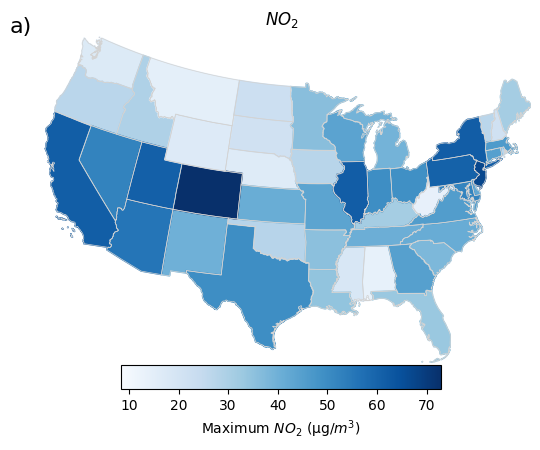

In [33]:
def plot_basemap(df, year, col, state_name = 'NAME', annot='a)', 
                 cmap_title=None, title=None, adjust=True): 
    df = df[df['year'] == year]
    pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
    pop_lookup['District of Columbia'] = pop_lookup['District Of Columbia']
    m, b = draw_us_map(pop_lookup, df, col, annot='a)', cmap_title=cmap_title, 
                       title=title, adjust=adjust)
    return df

cmap_title = 'Maximum $NO_2$ (μg/$m^3$)'
title = '$NO_2$ '
df = plot_basemap(mdf, 2010, 'max', state_name='State Name', annot='a)', 
                  cmap_title=cmap_title, title=title, adjust=False)

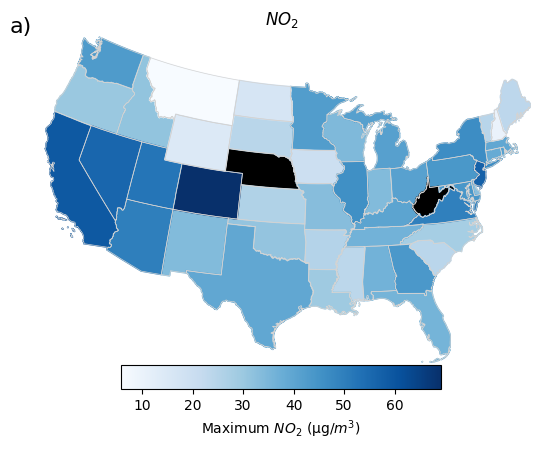

In [34]:
cmap_title = 'Maximum $NO_2$ (μg/$m^3$)'
title = '$NO_2$ '
df = plot_basemap(mdf, 2019, 'max', state_name='State Name', annot='a)', 
                  cmap_title=cmap_title, title=title, adjust=False)

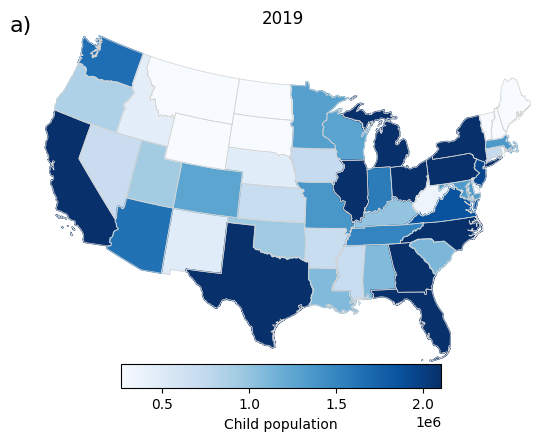

In [60]:
cmap_title = 'Child population'
title = '2019'
_ = plot_basemap('2019', 'population', state_name='NAME', annot='a)', 
                  cmap_title=cmap_title, title=title, adjust=True)

In [61]:
def calcorr(x):
    y = range(0, len(x))
    return np.corrcoef(x,y)[0][1]

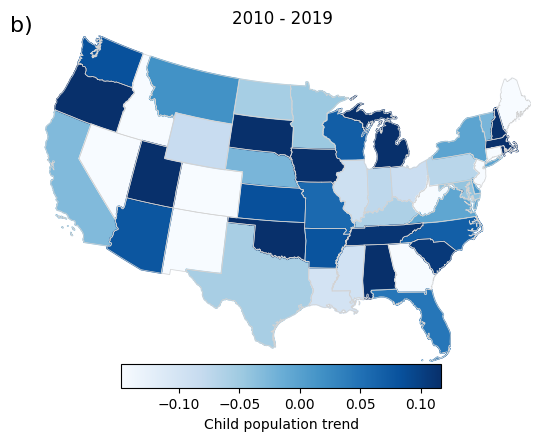

,fips,state_code,year,population,state_name,pred_wght
0,1001,1,2010,14541,Alabama,NaN
1,1001,1,2011,14383,Alabama,NaN
2,1001,1,2012,14168,Alabama,NaN
3,1001,1,2013,13741,Alabama,NaN
4,1001,1,2014,13614,Alabama,NaN
...,...,...,...,...,...,...
31415,56045,56,2015,1556,Wyoming,12.715851
31416,56045,56,2016,1559,Wyoming,10.340000
31417,56045,56,2017,1434,Wyoming,NaN
31418,56045,56,2018,1442,Wyoming,NaN


In [62]:
def plot_basemap_for_trend(col, state_name = 'NAME', annot='b)', 
                  cmap_title=cmap_title, title=title, adjust=False):    
    df = pd.read_csv(data_file)
    mdf = df.groupby(['state_code']).agg({'population': list, 'state_name': 'first'}).reset_index()
    mdf[col] = mdf['population'].apply(calcorr)
    
    pop_lookup = {row[state_name]: row[col] for index, row in mdf.iterrows()}
    pop_lookup['District of Columbia'] = pop_lookup['District Of Columbia']
    m, b = draw_us_map(pop_lookup, mdf, col, adjust=adjust, 
                       cmap_title=cmap_title, title=title,annot=annot)
    return df

cmap_title= 'Child population trend'
title="2010 - 2019"
plot_basemap_for_trend('corr', state_name='state_name', annot='b)', 
                  cmap_title=cmap_title, title=title, adjust=True)

In [ ]:
if __name__ == "__main__":
    df = pd.DataFrame()
    for year in range(2010, 2020):
        tdf, data = get_county_and_colors(year, 'fips', 'pred_wght')
        df = df.append(tdf)
        l = df['incidences_trap'].tolist()
        q1, q2, q3, q01, q85 = np.percentile(l, 25), np.percentile(l, 50), np.percentile(l, 75), np.percentile(l, 10), np.percentile(l, 85)
        df["col_2_norm"] = df['incidences_trap'].apply(normalize, args=(q1, q2, q3, q01, q85))
        df["col_2_norm"] = (df["col_2_norm"] - df["col_2_norm"].min())/ (df["col_2_norm"].max() - df["col_2_norm"].min())
  

    cmap = plt.get_cmap('Reds')
    for year in range(2010, 2020):
        m = draw_us_map()
        tdf = df[df['year'] == year]
        ax = plt.gca() 
        for index, county in enumerate(m.counties_info):
            fips = "{}{}".format(county.get('STATEFP'), county.get('COUNTYFP'))
            tdf['fips'] = tdf['fips'].astype(str)
            try:
                color = tdf.loc[tdf["fips"] == fips, "col_2_norm"].item()
            except:
                color = np.nan
            shapenum = county.get('SHAPENUM')
            countyseg = m.counties[shapenum-1]
            if not pd.isna(color):
                poly = Polygon(countyseg, facecolor=cmap(color))  # edgecolor="white"
                ax.add_patch(poly)    

        plt.title('Asthma incidences due to TRAP for {}'.format(year))
        # Get rid of some of the extraneous whitespace matplotlib loves to use.
        plt.tight_layout(pad=0, w_pad=0, h_pad=0)
        plt.savefig("output_images/basemap_trap/{}.png".format(year), bbox_inches='tight')
        plt.show()
        
        
        
        
        
        
        
        

In [ ]:
df

In [ ]:
plt.boxplot([i for i in df['col_2_norm'].tolist() if not pd.isna(i)])

In [ ]:
df = pd.read_csv('data/ambient_no2/daily_42602_2018.csv')

In [ ]:
def get_county_fips(x):
    x = str(x)
    if len(x) == 1:
        return "00{}".format(x)
    elif len(x) == 2:
        return "0{}".format(x)
    else:
        return x

df['county_fips'] = df['County Code'].apply(get_county_fips)
df['STATE'] = df['State Code'].astype(str)
df['fips'] = df['STATE'] + df['county_fips']

In [ ]:
len(df['fips'].unique())